# Compare analyzers on MNIST

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb)

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import matplotlib.pyplot as plt

import imp
import numpy as np
import os

from functools import partial
import keras
import keras.backend as K
import keras.models



# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

Using TensorFlow backend.


In [20]:
from innvestigate.analyzer import ReverseAnalyzerBase
from innvestigate.analyzer.relevance_based.relevance_analyzer import DeepTaylor

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras as kutils


import innvestigate.utils.keras.graph as kgraph



import innvestigate.layers as ilayers



## Data
Load the dataset and keep some images from the test set for the analysis.

In [4]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [17]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

scores = mnistutils.train_model(model, data, batch_size=256, epochs=10)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Epoch 1/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.1995 - acc: 0.9408
Epoch 2/10
60000/60000 [==============================] - 97s 2ms/step - loss: 0.0439 - acc: 0.9866
Epoch 3/10
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0269 - acc: 0.9919
Epoch 4/10
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0193 - acc: 0.9938
Epoch 5/10
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0130 - acc: 0.9957
Epoch 6/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0075 - acc: 0.9975
Epoch 7/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0071 - acc: 0.9974
Epoch 8/10
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0037 - acc: 0.9990
Epoch 9/10
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0054 - acc: 0.9985
Epoch 10/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.0045 - acc: 

In [21]:
model.save_weights('conv-mnist-weights.h5')

In [22]:
model.load_weights('conv-mnist-weights.h5')

In [23]:
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

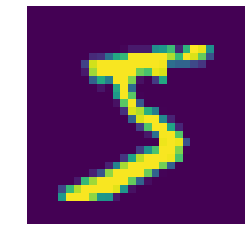

In [36]:
def plot_digit(x):
    plt.imshow(x.reshape((28, 28))) 
    plt.axis('off')
plot_digit(data[0][0,:])

## DeepLift

In [40]:
class DeepLift(ReverseAnalyzerBase):
    
    def _default_reverse_mapping(self, Xs, Ys, reversed_Ys, reverse_state):
        return ilayers.GradientWRT(len(Xs))(Xs+Ys+reversed_Ys)

    def fit(self, *args, **kwargs):
        # initialize the reference input (black image)
        x_0 = np.zeros([1] + list(K.int_shape(model_wo_softmax.input)[1:]))
        
        # get input tensor for every kernel layer ()
        intermediate_inputs = []
        layers_with_kernel = []
        for l in self._model.layers:
            if kchecks.contains_kernel(l):
                layers_with_kernel.append(l.name)
                intermediate_inputs.append(l.input)

        # ignore the first input layer, also include the last output
        # for adjusting the relevence score before propagating
        intermediate_inputs = intermediate_inputs[1:] + [model_wo_softmax.output]
        
        self.rootpoints_for_kernel_layers = dict(
                zip(
                    layers_with_kernel + ['rel_score'],
                    [x_0] + K.function([model_wo_softmax.input], intermediate_inputs)([x_0])
                )
            )
#       print('We have %d int. inputs' % (len(self.rootpoints_for_kernel_layers)))
        

    def _get_state(self):
        state = super(ReverseAnalyzerBase, self)._get_state()    
        state.update({
            'rootpoints_for_kernel_layers': self.rootpoints_for_kernel_layers
        })

        return state

    def _create_analysis(self, *args, **kwargs):
        # TODO: Adjust the last layer with relevance of the reference input
        
        rootpoints = self._get_state()['rootpoints_for_kernel_layers']
        
        for l in self._model.layers:
            if l.name in self.rootpoints_for_kernel_layers:
                l._deeplift_rootpoint = rootpoints[l.name]

        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.contains_kernel(layer),
            DeepLiftRule,

            name="deeplift_rule",
        )
        
        return super(DeepLift, self)._create_analysis(*args, **kwargs)
    
class DeepLiftRule(kgraph.ReverseMappingBase):
    """                                                                                                                                                                              
    Basic DeepLiftRule decomposition rule (for layers with weight kernels),                                                                                                                   
    which considers the bias a constant input neuron.                                                                                                                                
    """

    def __init__(self, layer, state, rootpoints=None, bias=True):
        # Copy forward layer, but without activations
        self._layer_wo_act = kgraph.copy_layer_wo_activation(layer,
                                                             keep_bias=bias,
                                                             name_template="reversed_kernel_%s")
        
        self.Xs_root = layer._deeplift_rootpoint
        xs_root_input = keras.layers.Input(shape=self.Xs_root.shape[1:])
        self.Zs_root = K.function([xs_root_input], kutils.apply(self._layer_wo_act, [xs_root_input]))([self.Xs_root])[0]


    def apply(self, Xs, Ys, Rs, reverse_state):
        grad = ilayers.GradientWRT(len(Xs))

        Zs = kutils.apply(self._layer_wo_act, Xs)
        
        Zs_adjusted = [keras.layers.Lambda(lambda z: z - self.Zs_root)(Zs[0])]
        Xs_adjusted = [keras.layers.Lambda(lambda z: z - self.Xs_root)(Xs[0])]
        
        # Divide incoming relevance by the activations.    
        tmp = [ilayers.SafeDivide()([a, b])
               for a, b in zip(Rs, Zs_adjusted)]
        
        # Propagate the relevance to input neurons                                                                                                                                   
        # using the gradient.               
        tmp = iutils.to_list(grad(Xs+Zs+tmp))

        # Re-weight relevance with the input values.                                                                                                                                 
        return [keras.layers.Multiply()([a, b])
                for a, b in zip(Xs_adjusted, tmp)]
    

In [26]:
deeplift_analyzer = DeepLift(model_wo_softmax)
deeplift_analyzer.fit()

In [27]:
deeplift_analyzer._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total para

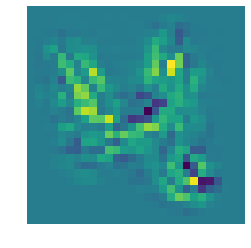

In [38]:
ax = deeplift_analyzer.analyze(data[0][20,:].reshape((1, 28, 28, 1)))
plot_digit(ax)

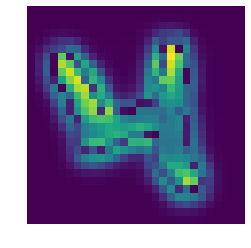

In [39]:
dtd = DeepTaylor(model_wo_softmax)
ax = dtd.analyze(data[0][20,:].reshape((1, 28, 28, 1)))
plot_digit(ax)

# END!

In [ ]:
for k, v in deeplift_analyzer._reversed_tensors:
    print(k, np.min(v), np.max(v))

In [46]:
for k, v in analyzer._reversed_tensors:
    print(k, np.min(v), np.max(v))

<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>

In [454]:
deeplift_analyzer._model.input.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [97]:
intermediate_outputs = []
for l in model_wo_softmax.layers:
    if kchecks.contains_kernel(l):
        print(l)
        intermediate_outputs.append(l.input)

print('We have %d int. outputs' % (len(intermediate_outputs)))
get_intermediate_outputs = K.function([model_wo_softmax.input], intermediate_outputs[1:])

int_outputs = get_intermediate_outputs([x_zeros])

We have 4 int. outputs


In [489]:
kutils.apply(model_wo_softmax.layers[1], [K.variable(x_zeros)])

[<tf.Tensor 'conv2d_3_9/Relu:0' shape=(1, 26, 26, 32) dtype=float32>]

In [490]:
kutils.apply(model_wo_softmax.layers[1], [model_wo_softmax.input])

[<tf.Tensor 'conv2d_3_10/Relu:0' shape=(?, 26, 26, 32) dtype=float32>]

In [483]:
keras.layers.Input(tensor=K.variable(x_zeros))

<tf.Variable 'Variable_38:0' shape=(1, 28, 28, 1) dtype=float32_ref>

In [477]:
model_wo_softmax.layers[1].input_shape

(None, 28, 28, 1)

In [86]:
from keras.models import Model
from keras import backend as K


In [94]:
get_3rd_layer_output = K.function([model_wo_softmax.input],
                                  [model_wo_softmax.layers[3].input])
get_3rd_layer_output([x_zeros])[0].shape

(1, 24, 24, 64)

In [469]:
x_zeros = np.zeros((1, 28, 28, 1))

In [105]:
K.int_shape(model_wo_softmax.input)[1:]

(28, 28, 1)

In [163]:
# x_0 = np.zeros([1] + list(K.int_shape(model_wo_softmax.input)[1:]))
x_0 = data[0][0,:].reshape((1, 28, 28, 1))
intermediate_outputs = []
layers_with_kernel = []
for l in model_wo_softmax.layers:
    if kchecks.contains_kernel(l):
        layers_with_kernel.append(l.name)
        print('Layer %s has kernel' % l.name)
        intermediate_outputs.append(l.input)

intermediate_outputs = intermediate_outputs[1:] + [model_wo_softmax.output]
get_intermediate_outputs = K.function([model_wo_softmax.input], intermediate_outputs)

rootpoints_for_kernel_layers = dict(zip(layers_with_kernel + ['rel_score'], [x_0] + get_intermediate_outputs([x_0])))
print('We have %d int. inputs' % (len(rootpoints_for_kernel_layers)))

Layer conv2d_3 has kernel
Layer conv2d_4 has kernel
Layer dense_4 has kernel
Layer dense_6 has kernel
We have 5 int. inputs


In [178]:
rootpoints_for_kernel_layers['rel_score'].shape

(1, 10)

In [159]:
model_wo_softmax.layers[1].name

'conv2d_3'

In [130]:
model_wo_softmax.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4719104   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total para

In [131]:
model_wo_softmax.output

<tf.Tensor 'dense_6/BiasAdd:0' shape=(?, 10) dtype=float32>

In [176]:
K.function([model_wo_softmax.input], [model_wo_softmax.output])([np.zeros((1, 28, 28, 1))])

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)]

In [227]:
model_wo_softmax.outputs

[<tf.Tensor 'dense_6/BiasAdd:0' shape=(?, 10) dtype=float32>]

In [179]:
model_wo_softmax.output.shape

TensorShape([Dimension(None), Dimension(10)])

In [182]:
model_wo_softmax.output == model_wo_softmax.output

True